In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def initialize(particlePerCell, nodeNum, domainHeight, dt, simulationTime, randomParticle):
    if randomParticle:
        particleNum = (nodeNum - 1) * (particlePerCell)   # Number of particles in 'x' dimension # 1D
        dx = domainHeight / (nodeNum - 1)  # Node spacing
        dp = domainHeight / (particleNum - 1)  # Particle spacing
        xI = np.arange(0, domainHeight + dx - 1e-15, dx)  # Node locations
        np.random.seed(0)  # Set random seed for reproducibility
        xp = np.zeros(particleNum)
        for i in range(nodeNum - 1):
            for ppc in range (particlePerCell):
                if i == 0:
                    xp[particlePerCell*i + ppc] = dx * np.random.rand(1) + dx * i
                    xp[particlePerCell*i] = 0
                elif i == nodeNum - 2:
                    xp[particlePerCell*i + ppc] = dx * np.random.rand(1) + dx * i
                    xp[particlePerCell*i + particlePerCell - 1] = domainHeight
                else:
                    xp[particlePerCell*i + ppc] = dx * np.random.rand(1) + dx * i
    else:
        particleNum = (nodeNum - 1) * (particlePerCell)  # Number of particles in 'y' dimension # 1D
        # particleNum = (nodeNum - 1) * (particlePerCell - 1) + 1
        dx = domainHeight / (nodeNum - 1)  # Node spacing
        dp = domainHeight / (particleNum - 1)  # Particle spacing
        xI = np.arange(0, domainHeight + dx - 1e-12, dx)  # Node locations
        xp = np.zeros(particleNum)
        for i in range(nodeNum - 1):
            for ppc in range (particlePerCell):
                if i == 0:
                    xp[particlePerCell*i + ppc] = dx * ppc / (particlePerCell) + dx * i
                    xp[particlePerCell*i] = 0
                elif i == nodeNum - 2:
                    xp[particlePerCell*i + ppc] = dx * (ppc+1) / particlePerCell + dx * i
                    xp[particlePerCell*i + particlePerCell - 1] = domainHeight
                else:
                    xp[particlePerCell*i + ppc] = dx * (ppc+1) / (particlePerCell+1) + dx * i
        # xp = np.linspace(0, domainHeight, particleNum)  # Particle locations

    # Node displacement
    uI = np.zeros_like(xI)

    # Node pressure
    pI = np.zeros_like(xI)

    # Total number of timesteps
    timeStepNum = simulationTime / dt

    # Midpoint between each particle
    midpoint = (xp[1:] - xp[:-1]) / 2 + xp[:-1]

    # Calculate each particle volume
    vp = midpoint[1:] - midpoint[:-1]
    vp = np.concatenate(([midpoint[0]], vp, [domainHeight - midpoint[-1]]))

    # Initialize normal vector
    n = np.zeros(particleNum)
    n[0] = -1  # Normal vector at y = 0 (Dirichlet BC)
    n[-1] = 1  # Normal vector at y = Ly (traction BC)

    return particleNum, dx, dp, xp, vp, xI, uI, pI, n, timeStepNum

In [4]:
def initialize_terzaghi(E, nu, kh, gammaf, nf, Kf):
    K = E / (3 * (1 - 2 * nu))  # Bulk modulus
    G = E / (2 * (1 + nu))  # Shear modulus
    kf = kh / gammaf  # Permeability
    Ks = K * 1e10  # Solid grain bulk modulus
    alpha = 1 - K / Ks  # Biot's coefficient
    Q_inv = (alpha - nf) / Ks + nf / Kf  # 1 / Q
    return kf, Ks, alpha, Q_inv, K, G

In [5]:
def GetRK(xI, dx, xp, supportNorm): # Node location, Node spacing, Particle location, Normalized RK approximation support size
    nodeNum = len(xI)                   # Number of background grid nodes
    particleNum = len(xp)               # Number of locations to evaluate the RK shape functions at
    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    phi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape functions
    dphi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum):
        M = np.zeros((2, 2))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = abs(xp[idx] - xI[I]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            PxI = np.array([1, xI[I] - xp[idx]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J] - xp[idx]])
            Ploc = np.array([1, 0])
            PlocGrad = np.array([0, 1])
            phi[J, idx] = w[J, idx] * np.dot(Ploc, np.linalg.solve(M, PxI))
            dphi[J, idx] = w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    return phi, dphi

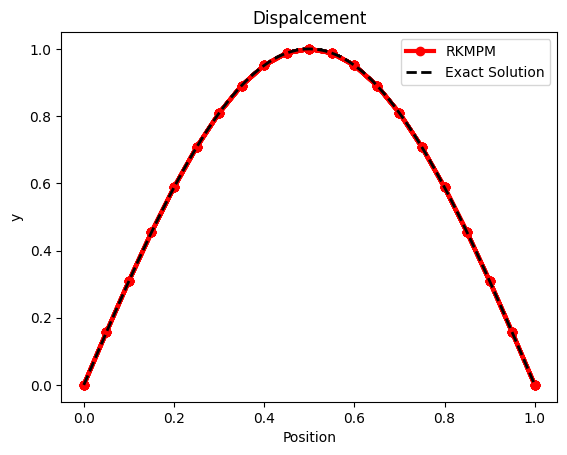

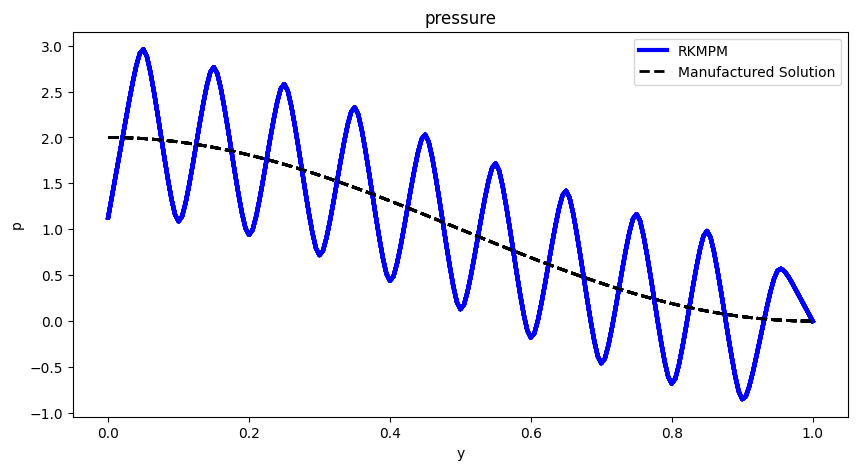

In [17]:
randomParticle = False
E = 1
nu = 0.0
rho = 1
kh = 1e-5
gammaf = 10e3
nf = 0.2
Kf = 2.2e9
domainHeight = 1
dt = 1e-6
simulationTime = dt * 10
betaNorm = 1000
supportNorm = 1.5
amp = 1.0
g = 0e1
# traction = -1e1
dirichletBC = 0
tractionBC = domainHeight

# 進行初始化和其他設置
particlePerCell_array = [2]
nodeNum_array = [21]
t0 = dt * 0

for idx in range(len(nodeNum_array)):
    particlePerCell = particlePerCell_array[0]
    nodeNum = nodeNum_array[idx]
    particleNum, dx, dp, xp, vp, xI, uI, pI, n, timeStepNum = initialize(particlePerCell, nodeNum, domainHeight, dt, simulationTime, randomParticle)
    kf, Ks, alpha, Q_inv, K, G = initialize_terzaghi(E, nu, kh, gammaf, nf, Kf)

    uI = amp * np.exp(-t0) * np.sin(xI * np.pi)
    pI = amp * np.exp(-t0) * (np.cos(xI * np.pi) + 1)
    beta = betaNorm * E / dx
    zeroMatrix = np.zeros((nodeNum, nodeNum))
    Kuu = np.copy(zeroMatrix)
    Kup = np.copy(zeroMatrix)
    Kpu = np.copy(zeroMatrix)
    KppS = np.copy(zeroMatrix)
    KppH = np.copy(zeroMatrix)
    F = np.zeros(nodeNum)
    Q = np.copy(F)

    for i in range(int(simulationTime/dt)):
        phiU, dphiU = GetRK(xI, dx, xp, supportNorm)
        phiP, dphiP = GetRK(xI, dx, xp, supportNorm)

        for p in range(particleNum):
            Kuu = Kuu + E * np.outer(dphiU[:, p], dphiU[:, p]) * vp[p]
            Kup = Kup + alpha * np.outer(dphiU[:, p], phiP[:, p]) * vp[p]
            KppS = KppS + Q_inv * np.outer(phiP[:, p], phiP[:, p]) * vp[p]
            KppH = KppH + kf * np.outer(dphiP[:, p], dphiP[:, p]) * vp[p]
            F = F + phiU[:, p] * rho * g * vp[p]

            F = F - phiU[:, p] * amp * np.pi * np.exp(-i * dt) * np.sin(xp[p] * np.pi) * (alpha - np.pi * E) * vp[p]
            Q = Q - dt * phiU[:,p] * amp * (np.exp(-i*dt)*np.cos(xp[p]*np.pi)*(np.pi**2*kf-np.pi*alpha-Q_inv)-np.exp(-i*dt)*Q_inv) * vp[p]

            if p == 0:
                qf = -kf * (amp * np.exp(-i*dt)*-np.pi*np.sin(xp[p]*np.pi))
                Q = Q - phiU[:,p] * qf * 1
            if p == particleNum - 1:
                traction = 1 * amp * (E * np.exp(-i*dt)*np.pi*np.cos(xp[p]*np.pi)-alpha*np.exp(-i*dt)*(np.cos(xp[p]*np.pi)+1))
                F = F + phiU[:, p] * traction * 1

        J = np.block([[Kuu, -Kup], [Kup.T, (KppS + dt * KppH)]])
        Ext = np.concatenate([F, dt * Q])
        R = np.block([[zeroMatrix, zeroMatrix], [Kup.T, (KppS)]])
        J = np.delete(J, 0, axis=0)
        J = np.delete(J, 0, axis=1)
        J = np.delete(J, -1, axis=0)
        J = np.delete(J, -1, axis=1)
        R = np.delete(R, 0, axis=0)
        R = np.delete(R, 0, axis=1)
        R = np.delete(R, -1, axis=0)
        R = np.delete(R, -1, axis=1)
        Ext = np.delete(Ext, [0, -1])

        X = np.linalg.solve(J, np.dot(R, np.concatenate([uI[1:], pI[:-1]])) + Ext)
        uI = np.concatenate([[0],X[:nodeNum - 1]])
        pI = np.concatenate([X[nodeNum - 1:], [0]])

        for discretizationNum in range(len(nodeNum_array)):
            nodeNum = nodeNum_array[discretizationNum]

            xE = np.arange(0, domainHeight + 0.01, 0.01)

            displacementExact = amp * np.exp(-i*dt) * np.sin(xE * np.pi)
            pressureExact = amp * np.exp(-i*dt) * (np.cos(xE * np.pi) + 1)
            step = 0.005
            xc = np.arange(0, domainHeight + step, step)
            phiUc, dphiUc = GetRK(xI, dx, xc, supportNorm)
            pc = np.dot(pI, phiUc)

            if discretizationNum == len(nodeNum_array) - 1:
                plt.figure(1)
                plt.plot(xI, uI, 'ro-', linewidth=3)
                plt.plot(xE, displacementExact, 'k--', linewidth=2)
                plt.title("Dispalcement")
                plt.xlabel('Position')
                plt.ylabel('y')
                plt.legend(['RKMPM', 'Exact Solution'])

                plt.figure(2,(10,5))
                plt.plot(xc, pc, 'b-', linewidth=3)
                plt.plot(xE, pressureExact, 'k--', linewidth=2)
                plt.title("pressure")
                plt.xlabel('y')
                plt.ylabel('p')
                plt.legend(['RKMPM', 'Manufactured Solution'])

In [7]:
import numpy as np

i = np.array([1,2,3])
y = np.zeros(3)
y[:] = np.exp(i[:])
print(y)

[ 2.71828183  7.3890561  20.08553692]
